# Read all images

In [22]:
import os
import random
import shutil

all_data = {'crazing': [], 'inclusion': [], 'patches': [], 'pitted': [], 'rolled-in': [], 'scratches': []}

for f in os.listdir('origin/IMAGES'):
    all_data[f.split('_')[0]].append(f)

# randomly select validation data
VALID_NUM = 60
valid_set = {'crazing': [], 'inclusion': [], 'patches': [], 'pitted': [], 'rolled-in': [], 'scratches': []}
for c in all_data:
    for i in range(VALID_NUM):
        selected = random.choice(all_data[c])
        valid_set[c].append(selected)
        all_data[c].remove(selected)
        

# randomly select evaluation data
EVALUATE_NUM = 60
eval_set = {'crazing': [], 'inclusion': [], 'patches': [], 'pitted': [], 'rolled-in': [], 'scratches': []}
for c in all_data:
    for i in range(EVALUATE_NUM):
        selected = random.choice(all_data[c])
        eval_set[c].append(selected)
        all_data[c].remove(selected)

# clean the dirs
shutil.rmtree('test')
shutil.rmtree('train')
shutil.rmtree('valid')
os.mkdir('train')
os.mkdir('test')
os.mkdir('valid')

# copy image to the dir according to the list
for c in all_data:
    for f in all_data[c]:
        shutil.copy(f'origin/IMAGES/{f}', 'train')
    for f in valid_set[c]:
        shutil.copy(f'origin/IMAGES/{f}', 'valid')
    for f in eval_set[c]:
        shutil.copy(f'origin/IMAGES/{f}', 'test')

# Convert annotation to YOLO format

In [38]:
import xml.etree.ElementTree as ET
import os

classes = ['crazing', 'inclusion', 'patches', 'pitted_surface', 'rolled-in_scale', 'scratches']

def convert_bndbox(size, box):
    dw = 1./size[0]
    dh = 1./size[1]
    x = (box[0] + box[1])/2.0
    y = (box[2] + box[3])/2.0
    w = box[1] - box[0]
    h = box[3] - box[2]
    x = x*dw
    w = w*dw
    y = y*dh
    h = h*dh
    return (x,y,w,h)

def convert(in_name, out_name):
    
    in_file = open(in_name, 'r')
    out_file = open(out_name, 'w') # .txt
    
    tree = ET.parse(in_file)
    root = tree.getroot()
    size = root.find('size')  
    w = int(size.find('width').text)
    h = int(size.find('height').text)

    for obj in root.iter('object'):
        cls = obj.find('name').text
        if cls not in classes :
            continue
        cls_id = classes.index(cls)
        xmlbox = obj.find('bndbox')   
        box = (float(xmlbox.find('xmin').text), float(xmlbox.find('xmax').text), float(xmlbox.find('ymin').text), float(xmlbox.find('ymax').text))
        converted_box = convert_bndbox((w,h), box)
        
        out_file.write(str(cls_id) + " " + " ".join([str(s) for s in converted_box]) + '\n')

for folder in ['train', 'valid', 'test']:
    for f in os.listdir(f'{folder}/images'):
        file_name = f.split('.jpg')[0]
        convert(f'origin/ANNOTATIONS/{file_name}.xml', f'{folder}/labels/{file_name}.txt')


# Make image list

In [30]:
for folder in ['train', 'valid', 'test']:
    out_file = open(f'/home/cysun/Projects/dl_system/DL_system/DLSR-final/PyTorch-YOLOv3/data/custom/{folder}.txt', 'w')
    for f in os.listdir(f'{folder}/images'):
        out_file.write(f"../../../train_data/NEU-DET/{folder}/images/{f}\n")
    out_file.close()

## k-means clustering for anchor boxes 
* Reference: https://lars76.github.io/object-detection/k-means-anchor-boxes/

In [53]:
import numpy as np

def iou(box, clusters):
    x = np.minimum(clusters[:, 0], box[0])
    y = np.minimum(clusters[:, 1], box[1])

    intersection = x * y
    box_area = box[0] * box[1]
    cluster_area = clusters[:, 0] * clusters[:, 1]

    iou_ = intersection / (box_area + cluster_area - intersection)

    return iou_

def kmeans(boxes, k, dist=np.median):
    rows = boxes.shape[0]

    distances = np.empty((rows, k))
    last_clusters = np.zeros((rows,))

    np.random.seed()

    clusters = boxes[np.random.choice(rows, k, replace=False)]

    while True:
        for row in range(rows):
            distances[row] = 1 - iou(boxes[row], clusters)

        nearest_clusters = np.argmin(distances, axis=1)

        if (last_clusters == nearest_clusters).all():
            break

        for cluster in range(k):
            clusters[cluster] = dist(boxes[nearest_clusters == cluster], axis=0)

        last_clusters = nearest_clusters

    return clusters

def get_annoation_boxes(in_name):
    in_file = open(in_name, 'r')
    tree = ET.parse(in_file)
    root = tree.getroot()
    boxes = []
    
    for obj in root.iter('object'):
        xmlbox = obj.find('bndbox')   
#         boxes.append((float(xmlbox.find('xmin').text), float(xmlbox.find('ymin').text), float(xmlbox.find('xmax').text), float(xmlbox.find('ymax').text)))
        boxes.append((float(xmlbox.find('xmax').text) - float(xmlbox.find('xmin').text), float(xmlbox.find('ymax').text) - float(xmlbox.find('ymin').text)))
    
    return boxes

boxes = []

# get boxes from annoation files
for f in os.listdir(f'origin/ANNOTATIONS'):
    boxes = boxes + get_annoation_boxes(f"origin/ANNOTATIONS/{f}")

# compute k-means
print(kmeans(np.array(boxes), 9))    

[[ 46.  39.]
 [ 28. 185.]
 [172.  28.]
 [154. 193.]
 [ 74.  63.]
 [ 68. 133.]
 [134.  75.]
 [ 37.  77.]
 [ 19.  42.]]


# Analysis misclassified data

In [133]:
import pandas as pd
import plotly.express as px

not_detected_list = ['../../../train_data/NEU-DET/test/images/crazing_107.jpg', '../../../train_data/NEU-DET/test/images/crazing_12.jpg', '../../../train_data/NEU-DET/test/images/crazing_122.jpg', '../../../train_data/NEU-DET/test/images/crazing_128.jpg', '../../../train_data/NEU-DET/test/images/crazing_160.jpg', '../../../train_data/NEU-DET/test/images/crazing_168.jpg', '../../../train_data/NEU-DET/test/images/crazing_202.jpg', '../../../train_data/NEU-DET/test/images/crazing_205.jpg', '../../../train_data/NEU-DET/test/images/crazing_227.jpg', '../../../train_data/NEU-DET/test/images/crazing_230.jpg', '../../../train_data/NEU-DET/test/images/crazing_258.jpg', '../../../train_data/NEU-DET/test/images/crazing_295.jpg', '../../../train_data/NEU-DET/test/images/crazing_41.jpg', '../../../train_data/NEU-DET/test/images/crazing_48.jpg', '../../../train_data/NEU-DET/test/images/crazing_51.jpg', '../../../train_data/NEU-DET/test/images/crazing_52.jpg', '../../../train_data/NEU-DET/test/images/crazing_77.jpg', '../../../train_data/NEU-DET/test/images/crazing_80.jpg', '../../../train_data/NEU-DET/test/images/crazing_91.jpg', '../../../train_data/NEU-DET/test/images/inclusion_237.jpg', '../../../train_data/NEU-DET/test/images/pitted_surface_110.jpg', '../../../train_data/NEU-DET/test/images/pitted_surface_128.jpg', '../../../train_data/NEU-DET/test/images/pitted_surface_183.jpg', '../../../train_data/NEU-DET/test/images/pitted_surface_216.jpg', '../../../train_data/NEU-DET/test/images/pitted_surface_219.jpg', '../../../train_data/NEU-DET/test/images/pitted_surface_227.jpg', '../../../train_data/NEU-DET/test/images/pitted_surface_235.jpg', '../../../train_data/NEU-DET/test/images/pitted_surface_239.jpg', '../../../train_data/NEU-DET/test/images/pitted_surface_263.jpg', '../../../train_data/NEU-DET/test/images/pitted_surface_273.jpg', '../../../train_data/NEU-DET/test/images/pitted_surface_33.jpg', '../../../train_data/NEU-DET/test/images/pitted_surface_45.jpg', '../../../train_data/NEU-DET/test/images/pitted_surface_54.jpg', '../../../train_data/NEU-DET/test/images/pitted_surface_62.jpg', '../../../train_data/NEU-DET/test/images/pitted_surface_68.jpg', '../../../train_data/NEU-DET/test/images/rolled-in_scale_100.jpg', '../../../train_data/NEU-DET/test/images/rolled-in_scale_102.jpg', '../../../train_data/NEU-DET/test/images/rolled-in_scale_111.jpg', '../../../train_data/NEU-DET/test/images/rolled-in_scale_236.jpg', '../../../train_data/NEU-DET/test/images/rolled-in_scale_238.jpg', '../../../train_data/NEU-DET/test/images/rolled-in_scale_7.jpg']

not_detected_count = {'crazing': 0, 'inclusion': 0, 'patches': 0, 'pitted_surface': 0, 'rolled-in_scale': 0, 'scratches': 0}

for f in not_detected_list:
    for l in not_detected_count:
        if l in f.split('/')[-1]:
            not_detected_count[l] += 1

undetected_summary = {'class': [], 'ratio': []}
for l in not_detected_count:
    undetected_summary['class'].append(l)
    undetected_summary['ratio'].append(not_detected_count[l] / 60) 

df = pd.DataFrame(undetected_summary)
plot = px.bar(df, x='class', y='ratio', text='ratio')
plot.update_traces(texttemplate='%{text:.2f}', textposition='outside')
plot.update_layout(title_text='Undetected Ratio')
plot.show()

## copy undetected images to a dir

In [103]:
from shutil import copyfile

for f in not_detected_list:    
    print(f.split('/')[-1])
    f_name = f.split('/')[-1]
    copyfile(f'./origin/IMAGES/{f_name}', f'./undetected/{f_name}')
    print(f.split('/')[-1].split('.jpg')[0]+'.xml')
    f_name = f.split('/')[-1].split('.jpg')[0]+'.xml'
    copyfile(f'./origin/ANNOTATIONS/{f_name}', f'./undetected/{f_name}')

## Draw ground truth bounding box

In [130]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np


def get_bnd_box(label_file):
    """
    Get bounding box from a Pascal VOC annotation file.
    
    Args:
        label_file (str): label file name
    Returns:
        boxes (list): a list of bounding box information; each element consists of 4 attributes:
            x_min, x_max, y_min, y_max
    """
    
    in_file = open(label_file, 'r')
    
    tree = ET.parse(in_file)
    root = tree.getroot()
    size = root.find('size')  
    w = int(size.find('width').text)
    h = int(size.find('height').text)
    boxes = []

    for obj in root.iter('object'):
        cls = obj.find('name').text
        if cls not in classes :
            continue
        cls_id = classes.index(cls)
        xmlbox = obj.find('bndbox')   
        box = {'xmin': float(xmlbox.find('xmin').text), 
               'ymin': float(xmlbox.find('ymin').text), 
               'xmax': float(xmlbox.find('xmax').text), 
               'ymax': float(xmlbox.find('ymax').text)}
        boxes.append(box)        
    return boxes


def draw_bnd_box(img_label, rescale=1):
    """
    Draw bounding boxes on given images.
    Args:
        img_label (list): a list of tuples of (img, label), where img, label = file names
    """
    for img, label in img_label:
        im = np.array(Image.open(img), dtype=np.uint8)
        bnd_boxes = get_bnd_box(label)
        print(img_name)
        
        # Create figure and axes
        fig,ax = plt.subplots(1)

        # Display the image
        ax.imshow(im)
        
        for b in bnd_boxes:
            # Create a Rectangle patch
            rect = patches.Rectangle(
                (b['xmin']*rescale,b['ymin']*rescale), # left-bottom corner
                (b['xmax']-b['xmin'])*rescale, # bndbox width
                (b['ymax']-b['ymin'])*rescale, # bndbox height
                linewidth=2,edgecolor='r',facecolor='none')

            # Add the patch to the Axes
            ax.add_patch(rect)

        plt.show()    

## Display undetected images

crazing_107.jpg


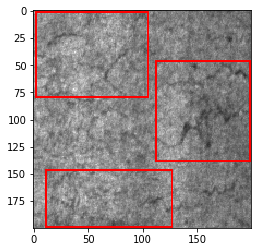

crazing_12.jpg


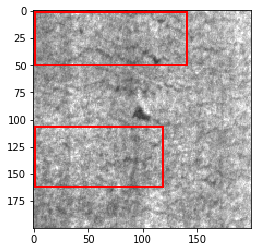

crazing_122.jpg


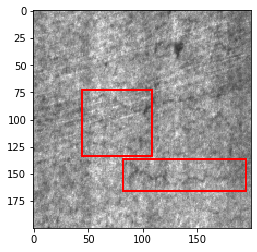

crazing_128.jpg


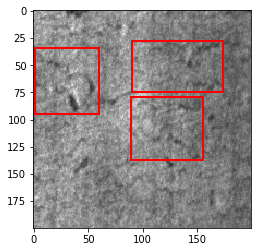

crazing_160.jpg


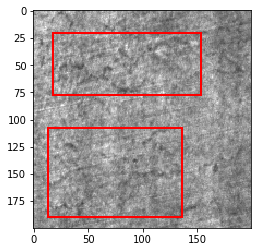

crazing_168.jpg


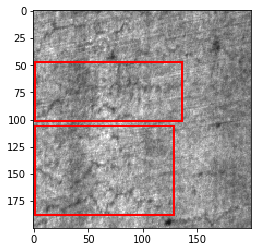

crazing_202.jpg


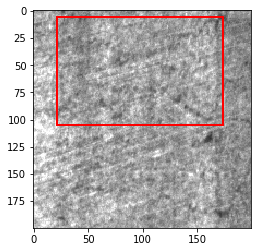

crazing_205.jpg


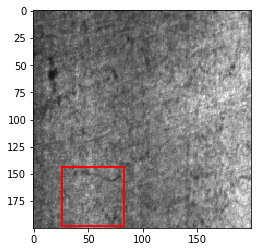

crazing_227.jpg


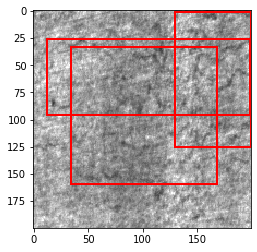

crazing_230.jpg


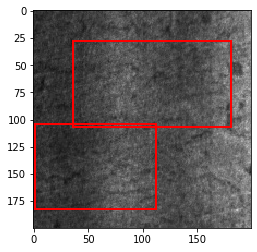

crazing_258.jpg


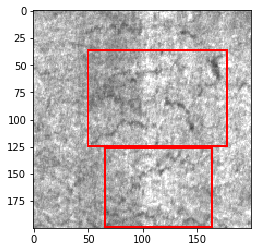

crazing_295.jpg


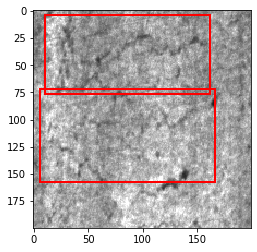

crazing_41.jpg


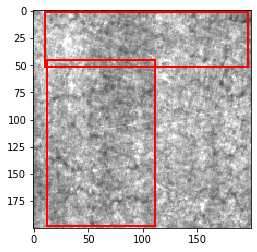

crazing_48.jpg


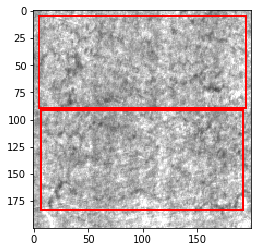

crazing_51.jpg


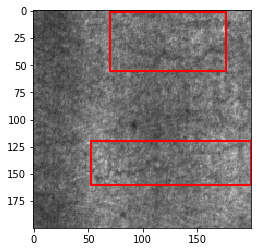

crazing_52.jpg


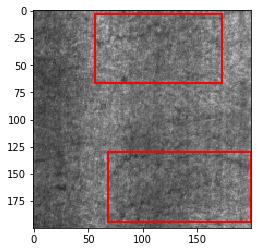

crazing_77.jpg


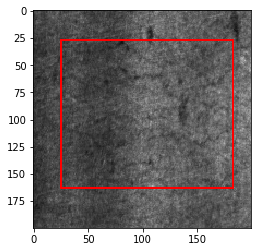

crazing_80.jpg


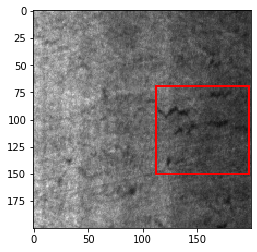

crazing_91.jpg


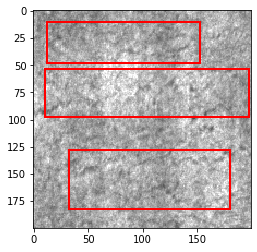

inclusion_237.jpg


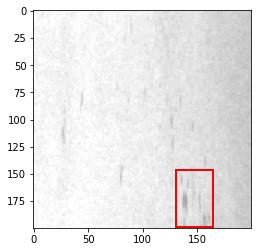

pitted_surface_110.jpg


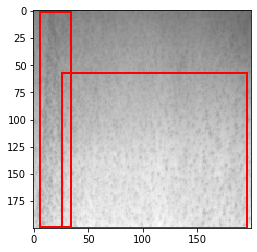

pitted_surface_128.jpg


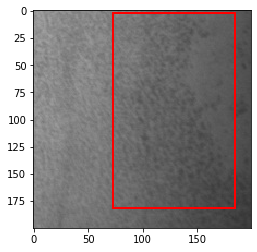

pitted_surface_183.jpg


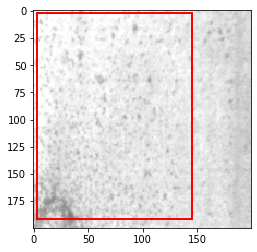

pitted_surface_216.jpg


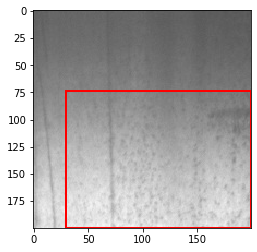

pitted_surface_219.jpg


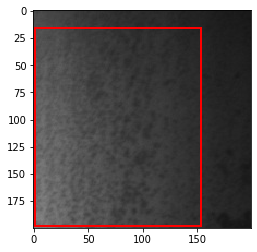

pitted_surface_227.jpg


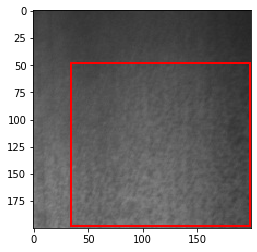

pitted_surface_235.jpg


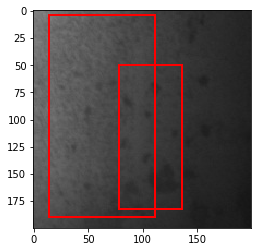

pitted_surface_239.jpg


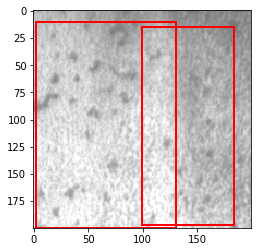

pitted_surface_263.jpg


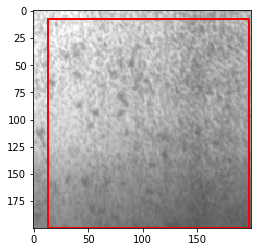

pitted_surface_273.jpg


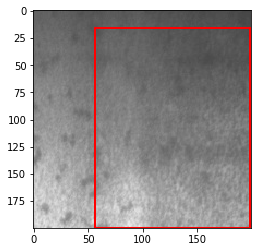

pitted_surface_33.jpg


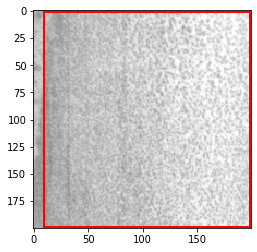

pitted_surface_45.jpg


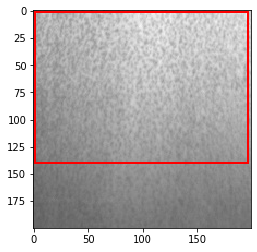

pitted_surface_54.jpg


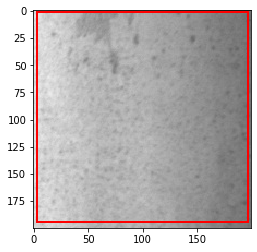

pitted_surface_62.jpg


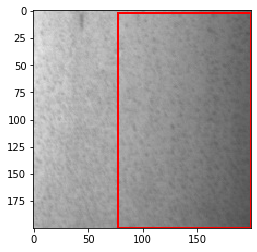

pitted_surface_68.jpg


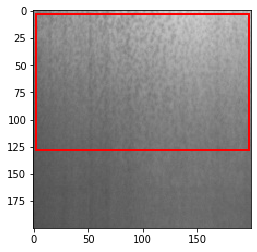

rolled-in_scale_100.jpg


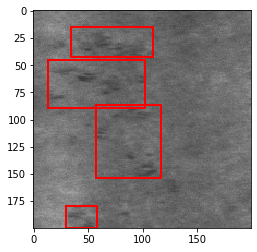

rolled-in_scale_102.jpg


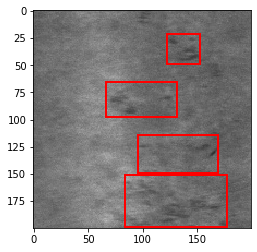

rolled-in_scale_111.jpg


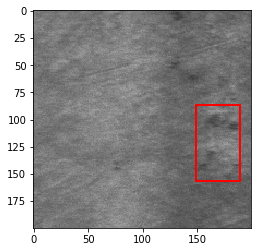

rolled-in_scale_236.jpg


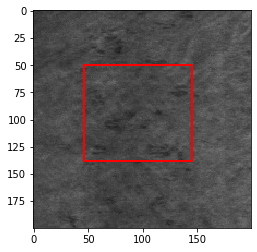

rolled-in_scale_238.jpg


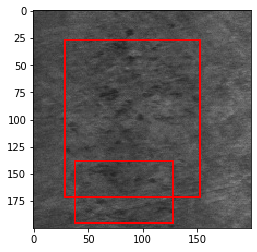

rolled-in_scale_7.jpg


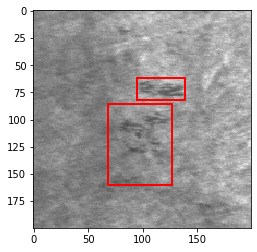

In [108]:
for f in not_detected_list:
    img_label = []
    img_name = f.split('/')[-1]
    label_name = f.split('/')[-1].split('.jpg')[0]+'.xml'
    img_label.append((f'{img_name}', f'undetected/label/{label_name}'))
    
    draw_bnd_box(img_label, )

## Display labels & detection results

crazing_15.png


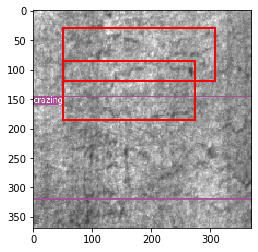

crazing_205.png


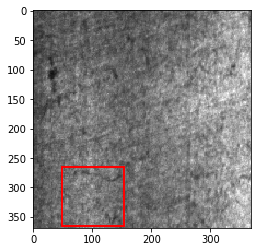

crazing_168.png


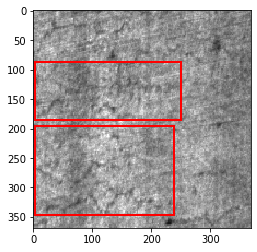

crazing_134.png


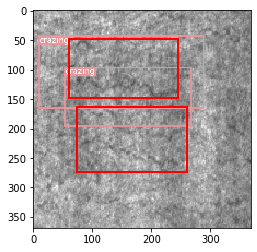

crazing_202.png


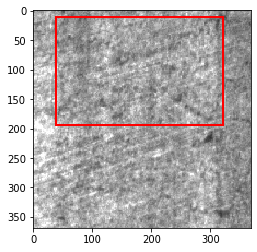

crazing_77.png


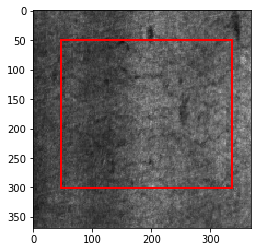

crazing_68.png


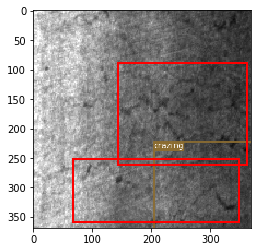

crazing_236.png


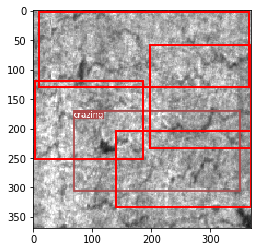

crazing_80.png


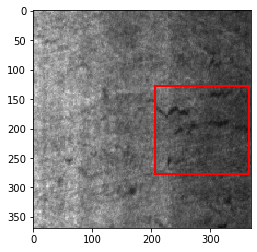

crazing_160.png


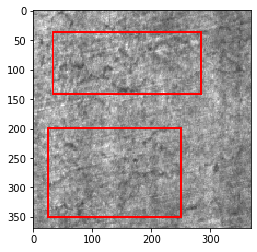

crazing_49.png


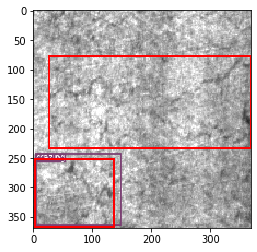

crazing_59.png


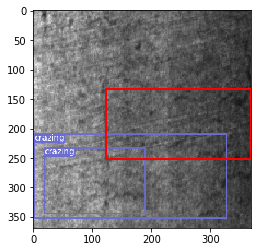

crazing_24.png


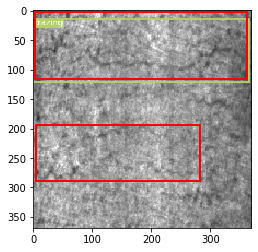

crazing_52.png


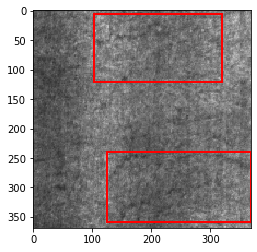

crazing_220.png


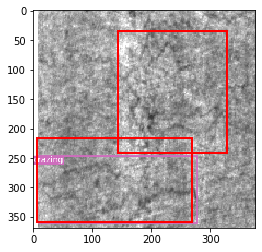

crazing_48.png


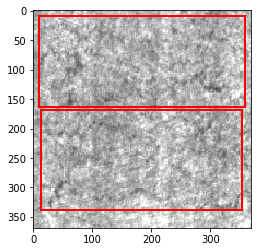

crazing_49.png


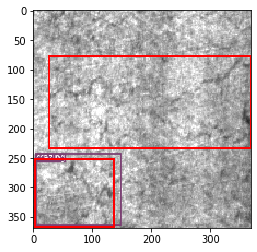

crazing_78.png


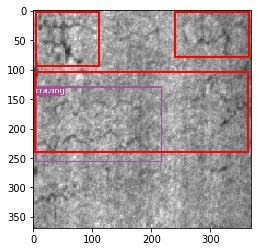

crazing_68.png


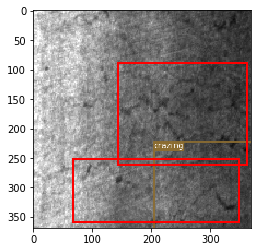

crazing_198.png


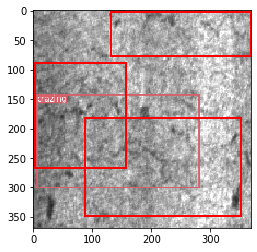

In [131]:
detected_list = os.listdir('./detected')

# random select 20 crazing images
import random

crazing_list = []
for f in detected_list:
    if 'crazing' in f:
        crazing_list.append(f)

crazing_samples = random.choices(crazing_list, k=20)

for f in crazing_samples:
    img_label = []
    img_name = f
    label_name = f.split('.png')[0]+'.xml'
    img_label.append((f'./detected/{img_name}', f'./origin/ANNOTATIONS/{label_name}'))
    
    draw_bnd_box(img_label, rescale=1.845)